In [4]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
import h5py

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, x):
        #return np.exp(x)/(np.sum(np.exp(x),axis=1)[:,None])
        return (np.exp(x)/(np.sum(np.exp(x))))
    
    def __softmax_deriv(self, a):
        #a = softmax(x)
        return (a * (1 - a))
    
    def __ReLU(self,x):
        return np.vectorize(lambda x:x if x>0 else 0)(x)
    
    def __ReLU_deriv(self,a):
        #a = ReLU()
        return np.vectorize(lambda x:1 if x>0 else 0)(a)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__logistic_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', dropout=None, W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.dropout=dropout
        self.dropout_vector = None
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input, mode):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        if (mode=='train' and self.dropout>0):
            self.dropout_vector = np.random.binomial(1, 1-self.dropout, size=input.shape)/(1-self.dropout)
            lin_output = np.dot(self.dropout_vector*input, self.W) + self.b
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
            )

        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input

        return self.output
    
    def backward(self, delta, output_layer=False):
        self.grad_W = (np.atleast_2d(self.dropout_vector*self.input if self.dropout>0 else self.input).T.dot(np.atleast_2d(delta)))
        self.grad_b = delta
        
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh'], dropout=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.mode = 'train'
        self.activation=activation
        self.dropout=dropout
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],self.dropout[i]))
            
    def train(self):
        self.mode = 'train'
    
    def test(self):
        self.mode = 'test'

    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input=input, mode=self.mode)
            input=output
        return output

    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        error = y*np.log(y_hat)
        loss = -np.sum(error)
        delta = (y_hat-y)
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    def fit(self,X,y,learning_rate=0.1, epochs=10):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.train()
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                if self.activation[-1] == 'softmax':
                    loss[it],delta=self.criterion_CELoss(y[i],y_hat)
                else:
                    loss[it],delta=self.criterion_MSE(y[i],y_hat)
                
                self.backward(delta)

                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    def predict(self, x):
        self.test()
        x = np.array(x)
        output = np.zeros(x.shape[0])
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i,:])
        return output
    
    def optimize(self, X, y, learning_rate=0.01, test_size=0.25, epochs=10, verbose=True):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        X=np.array(X)
        y=np.array(y)
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=test_size, shuffle=True)
        scaler = StandardScaler()
        #scaler = Normalizer()
        #scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        losses = np.zeros(epochs)
        accuracies_val = []
        accuracies_test = []
        
        for e in range(epochs):
            loss=np.zeros(X_train.shape[0])         
            
            self.test()
            yhat_train = self.forward(X_train)
            yhat_val = self.forward(X_val)
            
            # Calculate train and Test Accuracy
            accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
            accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
            
            self.train()
            for it in range(X_train.shape[0]):
                i=np.random.randint(X_train.shape[0])
                
                
                # forward pass
                y_hat = self.forward(X_train[i])

                # backward pass
                if self.activation[-1] == 'softmax':
                    loss[it],delta = self.criterion_CELoss(y_train[i],y_hat)
                else:
                    loss[it],delta = self.criterion_MSE(y_train[i],y_hat)
                
                self.backward(delta)

                # update
                self.update(learning_rate)
                
            self.test()
            yhat_train = self.forward(X_train)
            yhat_val = self.forward(X_val)
            accuracies_val.append(accuracy_train)
            accuracies_test.append(accuracy_val)
            
            if verbose:
                print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                      format(e, accuracy_train, accuracy_val, np.mean(loss)))
            
            losses[e] = np.mean(loss)
        return losses, accuracies_val, accuracies_test

In [ ]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,64,32,10],activation=[None, 'ReLU', 'ReLU', 'softmax'], dropout=[0, 0, 0, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.01,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')

Epoch: 0..
train Accuracy: 0.10335555555555556 
Validation Accuracy: 0.12133333333333333 
Loss: 0.5532555242731952 

Epoch: 1..
train Accuracy: 0.8624444444444445 
Validation Accuracy: 0.8476 
Loss: 0.37749771970350426 

Epoch: 2..
train Accuracy: 0.8786222222222222 
Validation Accuracy: 0.8607333333333334 
Loss: 0.34724235141318954 

Epoch: 3..
train Accuracy: 0.8777555555555555 
Validation Accuracy: 0.8522 
Loss: 0.3258745821826974 

Epoch: 4..
train Accuracy: 0.8846888888888889 
Validation Accuracy: 0.8623333333333333 
Loss: 0.3154830288160891 

Epoch: 5..
train Accuracy: 0.8840222222222223 
Validation Accuracy: 0.8590666666666666 
Loss: 0.3015172914055102 



Epoch: 0..
train Accuracy: 0.10875555555555555 
Validation Accuracy: 0.10873333333333333 
Loss: 0.5505329053184421 

Epoch: 1..
train Accuracy: 0.8651777777777778 
Validation Accuracy: 0.8517333333333333 
Loss: 0.3441838611341829 

Epoch: 2..
train Accuracy: 0.8810888888888889 
Validation Accuracy: 0.8559333333333333 
Loss: 0.3115651556755247 

Epoch: 3..
train Accuracy: 0.8911555555555556 
Validation Accuracy: 0.8599333333333333 
Loss: 0.29806389282704987 

Epoch: 4..
train Accuracy: 0.8976888888888889 
Validation Accuracy: 0.8632666666666666 
Loss: 0.2883581506613798 

Epoch: 5..
train Accuracy: 0.9004666666666666 
Validation Accuracy: 0.8630666666666666 
Loss: 0.26882767596767276 

Epoch: 6..
train Accuracy: 0.9033333333333333 
Validation Accuracy: 0.8668666666666667 
Loss: 0.25635955756361506 

Epoch: 7..
train Accuracy: 0.9083777777777777 
Validation Accuracy: 0.8635333333333334 
Loss: 0.2525654893459104 

Epoch: 8..
train Accuracy: 0.9095111111111112 
Validation Accuracy: 0.86633

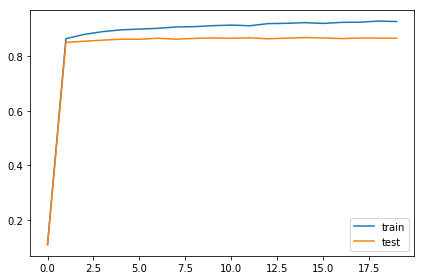

In [10]:
with h5py.File('data/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('data/train_label.h5','r') as H:
    label = np.copy(H['label'])
    
mlp = MLP([128,64,32,10],activation=[None, 'ReLU', 'logistic', 'softmax'], dropout=[0.2, 0.2, 0.2, 0])

losses, accuracies_train, accuracies_test = mlp.optimize(data, label, learning_rate=0.01,epochs=20)

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='test')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_sigmoid.png')